<a href="https://colab.research.google.com/github/CaiqueBorges/GNN_PublicTransport/blob/main/GNNs_PublicTransport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. DATASET A TRABALHAR

## 1.1 Rotulagem dos dados

In [1]:
!git clone https://github.com/CaiqueBorges/GNN_PublicTransport.git

Cloning into 'GNN_PublicTransport'...
remote: Enumerating objects: 12, done.
remote: Total 12 (delta 0), reused 0 (delta 0), pack-reused 12
Receiving objects: 100% (12/12), 45.18 MiB | 13.00 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/bin/bash: line 1: cd: /GNN_PublicTransport: No such file or directory


In [3]:
#from google.colab import files
import pandas as pd
#uploaded = files.upload()

df_input = pd.read_csv('GNN_PublicTransport/acessos_out_2023_GNN.csv')


In [4]:
#Filtrando apenas uma linha
df = df_input[df_input['Linha'] == 1]

In [5]:
for data in ['DataHora','DataHR_ini','DataHR_fim']:
  df[data] = pd.to_datetime(df[data], format='%Y/%m/%d %H:%M:%S') #Transformando as colunas em datetime
df['Dia'] = df['DataHora'].dt.date  # Cria uma nova coluna 'Dia' com a data extraída
df = df.rename(columns={'Trecho': 'Origem'}) # Renomeia a coluna 'Trecho' para 'Origem'
df = df.sort_values(by=['Dia', 'Cartao', 'DataHora'])  # Ordenando o DataFrame
df.head()

<ipython-input-5-d42866c591fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[data] = pd.to_datetime(df[data], format='%Y/%m/%d %H:%M:%S') #Transformando as colunas em datetime
<ipython-input-5-d42866c591fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[data] = pd.to_datetime(df[data], format='%Y/%m/%d %H:%M:%S') #Transformando as colunas em datetime
<ipython-input-5-d42866c591fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

,Linha,Carro,Cartao,DataHora,AcessoTipo,Latitude,Longitude,Sentido,N_Ciclo,DataHR_ini,DataHR_fim,km_viagem,Origem,TipoCartao,Dia
380307,1,39,114596794.0,2023-10-01 19:31:54,DEB,-5.856690,-35.250355,V,6,2023-10-01 18:26:06,2023-10-01 19:44:44,22.4727,Planalto,Com Urb1_Comum,2023-10-01
28728,1,5,116494602.0,2023-10-01 17:49:46,DEB,-5.871054,-35.221870,V,4,2023-10-01 17:13:36,2023-10-01 18:17:38,22.2702,BR 101,VT Urb1_Empresa,2023-10-01
141843,1,26,116736282.0,2023-10-01 11:20:28,DEB,-5.799652,-35.184200,V,6,2023-10-01 11:20:20,2023-10-01 12:28:16,22.1946,Mãe Luiza,VT Urb1_Empresa,2023-10-01
301056,1,39,116934026.0,2023-10-01 17:53:56,DEB,-5.811595,-35.209976,V,4,2023-10-01 17:10:04,2023-10-01 18:05:24,18.2495,Lagoa Nova - Prudente,VT Urb1_Empresa,2023-10-01
194845,1,5,117944826.0,2023-10-01 20:15:04,DEB,-5.774066,-35.201611,I,5,2023-10-01 19:28:46,2023-10-01 20:26:26,24.2679,Rocas,VT Urb1_Empresa,2023-10-01


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221309 entries, 380307 to 326308
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Linha       221309 non-null  int64         
 1   Carro       221309 non-null  int64         
 2   Cartao      178801 non-null  float64       
 3   DataHora    221309 non-null  datetime64[ns]
 4   AcessoTipo  221309 non-null  object        
 5   Latitude    221309 non-null  float64       
 6   Longitude   221309 non-null  float64       
 7   Sentido     221309 non-null  object        
 8   N_Ciclo     221309 non-null  int64         
 9   DataHR_ini  221309 non-null  datetime64[ns]
 10  DataHR_fim  221280 non-null  datetime64[ns]
 11  km_viagem   221298 non-null  float64       
 12  Origem      221309 non-null  object        
 13  TipoCartao  221309 non-null  object        
 14  Dia         221309 non-null  object        
dtypes: datetime64[ns](3), float64(4), int64(3), ob

In [6]:
# prompt: Quero que crie duas novas colunas baseadas no df['X'] e d['Y'], em que agrupe todos pontos a uma distância de 200 metros no ponto que há maior densidade de pontos ao redor

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances

def group_points(df, distance=200, lat = 'Latitude', long = 'Longitude'):
  """
  Agrupa os pontos do DataFrame df em grupos de pontos próximos.

  Args:
    df_rad: O DataFrame contendo os pontos com colunas "Latitude" e "Longitude" em radianos.
    distance: A distância máxima entre dois pontos para que eles sejam considerados próximos.

  Returns:
    Um DataFrame com os grupos de pontos.
  """

  # Cria um KDTree para os pontos.
  dbscan = DBSCAN(eps=distance, min_samples=1, metric='haversine')
  df['Cluster'] = dbscan.fit_predict(df[[lat, long]])

  # Cria colunas Cluster_X e Cluster_Y com as coordenadas do ponto central de cada cluster
  df_cluster_centers = df.groupby('Cluster').agg({lat: 'mean', long: 'mean'}).reset_index()
  df_cluster_centers.columns = ['Cluster', 'Cluster_X', 'Cluster_Y']
  df = pd.merge(df, df_cluster_centers, on='Cluster')

  return df

In [7]:
'''
Código para filtrar por Dia e assim não utilizar muita memória ram
'''
# Inicializa o DataFrame resultante
result_df = pd.DataFrame()
# Obtém os dias únicos no DataFrame
unique_days = df['DataHora'].dt.date.unique()

# Loop sobre cada dia
for day in unique_days:
  # Filtra o DataFrame para o dia atual
  df_day = df[df['DataHora'].dt.date == day].copy()
  # Usar a função para agrupar
  df_day = group_points(df_day)
  # Adiciona o resultado do dia ao DataFrame final
  result_df = pd.concat([result_df, df_day], ignore_index=True)

result_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221309 entries, 0 to 221308
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Linha       221309 non-null  int64         
 1   Carro       221309 non-null  int64         
 2   Cartao      178801 non-null  float64       
 3   DataHora    221309 non-null  datetime64[ns]
 4   AcessoTipo  221309 non-null  object        
 5   Latitude    221309 non-null  float64       
 6   Longitude   221309 non-null  float64       
 7   Sentido     221309 non-null  object        
 8   N_Ciclo     221309 non-null  int64         
 9   DataHR_ini  221309 non-null  datetime64[ns]
 10  DataHR_fim  221280 non-null  datetime64[ns]
 11  km_viagem   221298 non-null  float64       
 12  Origem      221309 non-null  object        
 13  TipoCartao  221309 non-null  object        
 14  Dia         221309 non-null  object        
 15  Cluster     221309 non-null  int64         
 16  Cl

In [8]:
result_df = result_df.rename(columns={'Cluster_X': 'X_1', 'Cluster_Y': 'Y_1'})

In [9]:
# Verifica a quantidade de valores únicos na coluna "Latitude"
num_unique_latitudes = result_df['Latitude'].nunique()
print(f"Número de valores únicos em Latitude: {num_unique_latitudes}")

# Verifica a quantidade de valores únicos na coluna "Cluster_Y"
num_unique_cluster_y = result_df['Y_1'].nunique()
print(f"Número de valores únicos em Y_1: {num_unique_cluster_y}")


Número de valores únicos em Latitude: 68537
Número de valores únicos em Y_1: 31


In [12]:
df = result_df

In [13]:
# Cria a coluna 'Destino', que será igual a 'Origem' anterior se 'Dia' e 'Cartao' forem iguais
df['Destino'] = df.groupby(['Dia', 'Cartao'])['Origem'].shift(-1)

# Quando for o último Embarque do dia, define 'Destino' como 'Origem' do primeiro Embarque do mesmo dia
last_entries = df.groupby(['Dia', 'Cartao']).tail(1).index
first_entries = df.groupby(['Dia', 'Cartao']).head(1).index
df.loc[last_entries, 'Destino'] = df.loc[first_entries, 'Origem'].values

df.loc[df['Cartao'].isnull(), 'Destino'] = None  # Define como None quando 'Cartao' é nulo

## 1.2 Apresentação dos dados georreferenciados

In [20]:
import geopandas as gpd
from shapely.geometry import Point

# Filtrar para o dia 25/10/2023
#df_filtrado = df[(df['DataHora'].dt.date == pd.to_datetime('25/10/2023').date()) & (df['DataHora'].dt.hour == 6)]
#df_filtrado = df[df['DataHora'].dt.date == pd.to_datetime('25/10/2023').date()]
# Filtrar pontos com Latitude igual a zero
df_filtrado = df_filtrado[df_filtrado['Y_1'] != 0]


In [21]:
import folium
from folium.plugins import MarkerCluster

# Criar um mapa centrado nas coordenadas médias dos pontos filtrados
centro_mapa = [df_filtrado['X_1'].mean(), df_filtrado['Y_1'].mean()]
mapa = folium.Map(location=centro_mapa, zoom_start=11)

# Criar um cluster de marcadores para melhorar a visualização
marker_cluster = MarkerCluster().add_to(mapa)

# Adicione pontos ao mapa
for index, row in df_filtrado.iterrows():
    folium.Marker([row['X_1'], row['Y_1']]).add_to(marker_cluster)

# Exibir o mapa
mapa

In [16]:
cores_linha = {
    1: 'blue',
    2: 'green',
    3: 'red',
    4: 'purple',
    5: 'orange',
    6: 'yellow',
    7: 'brown',
    8: 'cyan'
}

In [ ]:
import folium
from folium.plugins import MarkerCluster

# Criar um mapa centrado nas coordenadas médias dos pontos filtrados
centro_mapa = [df_filtrado['X_1'].mean(), df_filtrado['Y_1'].mean()]
mapa = folium.Map(location=centro_mapa, zoom_start=11)

# Adicione pontos ao mapa
for index, row in df_filtrado.iterrows():
  cor = cores_linha[row['Linha']]
  folium.Marker(
      location=[row['X_1'], row['Y_1']],
      popup=str(row['DataHora']),
      icon=folium.Icon(color='red',
                        icon='circle',
                        prefix='fa',
                        icon_color=cor,
                        icon_size=(2, 2),
                        shadow_size=(0,0))
  ).add_to(mapa)

# Adicionar uma legenda personalizada
legenda_html = '<div style="position: fixed; bottom: 50px; left: 50px; background-color: white; padding: 10px; border: 2px solid grey; z-index: 1000;">'
legenda_html += 'Linhas'
for valor, cor in cores_linha.items():
    legenda_html += f'<p style="color:{cor};">{valor}</p>'
legenda_html += '</div>'
mapa.get_root().html.add_child(folium.Element(legenda_html))

# Exibir o mapa
mapa

# 2. GRAPH NEURAL NETWORKS (GNNs)

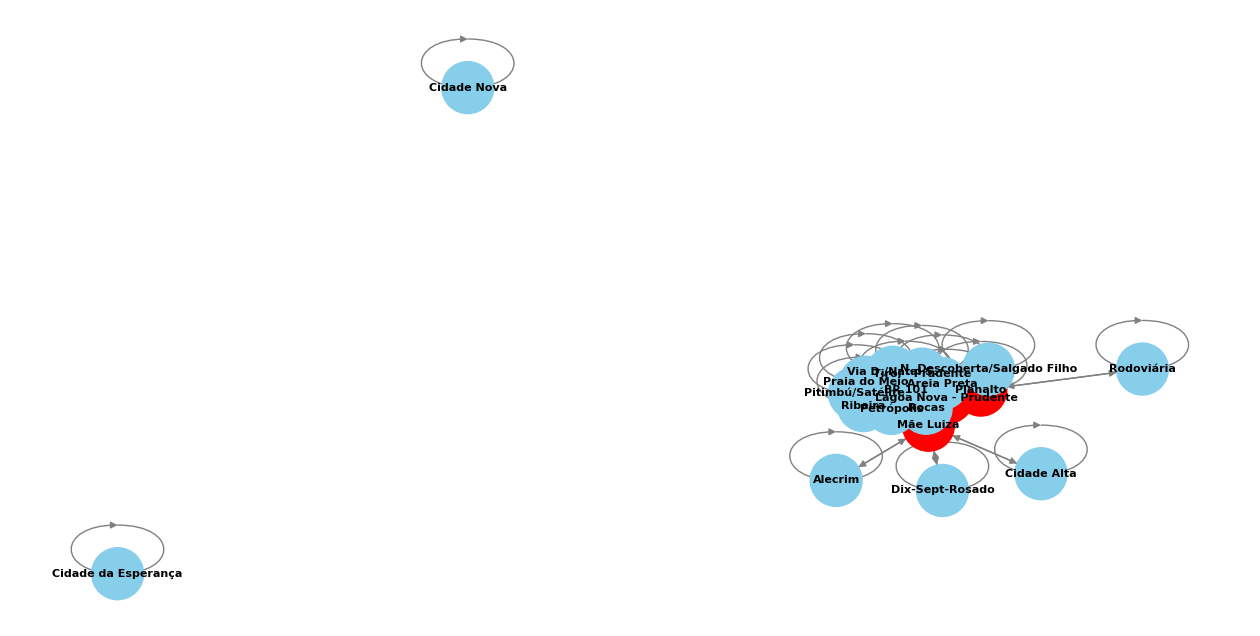

In [18]:
import matplotlib.pyplot as plt
import networkx as nx

df_filtered = df.dropna(subset=['Destino']) #Filtrando quem está rotulado

# Criar um grafo direcionado usando NetworkX
G = nx.from_pandas_edgelist(df_filtered, source='Origem', target='Destino', create_using=nx.DiGraph())

# Calcular a centralidade de grau
degree_centrality = nx.degree_centrality(G)

# Obter os 4 nós mais importantes
important_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:4]

# Cria um dicionário de cores para os nós
node_colors = ['red' if node in important_nodes else 'skyblue' for node in G.nodes]


# Visualiza o grafo
fig, ax = plt.subplots(figsize=(16, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=1400, node_color=node_colors, font_size=8, edge_color='gray', arrowsize=10)
plt.show()

In [ ]:
important_nodes

['Planalto', 'Via D./Natal S.', 'BR 101', 'Mãe Luiza']

# REFERÊNCIA DE GNNs

## A Comprehensive Introduction to Graph Neural Networks (GNNs)

by Abid Ali Awan

Jul 2022

https://www.datacamp.com/tutorial/comprehensive-introduction-graph-neural-networks-gnns-tutorial


Learn everything about Graph Neural Networks, including what GNNs are, the different types of graph neural networks, and what they're used for. Plus, learn how to build a Graph Neural Network with Pytorch.

Let’s learn about the complex Graph dataset: [Jazz Musicians Network](https://datarepository.wolframcloud.com/resources/Jazz-Musicians-Network). It contains 198 nodes and 2742 edges. In the community graph plot below, different colors of nodes represent various communities of Jazz musicians and the edges connecting them. There is a web of collaboration where a single musician has relationships within and outside the community.


<center>
<img width="200" src="https://images.datacamp.com/image/upload/v1658404112/Community_Graph_7f57ef95f9.png">

<small> Community Graph Plot by Jazz Musicians Network </small>
 </center>


 Graphs are excellent in dealing with complex problems with relationships and interactions. They are used in pattern recognition, social networks analysis, recommendation systems, and semantic analysis. Creating graph-based solutions is a whole new field that offers rich insights into complex and interlinked datasets.





## Graphs with NetworkX

In this section, we will learn to create a graph using NetworkX.

The code below is influenced by Daniel Holmberg's blog on Graph Neural Networks in Python.

    

1. Create networkx’s DiGraph object “H”
2. Add nodes that contain different labels, colors, and size
3. Add edges to create a relationship between two nodes. For example, “(0,1)” means that 0 has a directional dependency on 1. We will create bidirectional relationships by adding “(1,0)”
4. Extract colors and sizes in the form of lists
5. Plot the graph using networkx’s draw function





In [ ]:
import networkx as nx


In [ ]:
H = nx.DiGraph()

#adding nodes
H.add_nodes_from([
  (0, {"color": "blue", "size": 250}),

  (1, {"color": "yellow", "size": 400}),

  (2, {"color": "orange", "size": 150}),

  (3, {"color": "red", "size": 600})


])


In [ ]:
#adding edges
H.add_edges_from([
  (0, 1),

  (1, 2),

  (1, 0),

  (1, 3),

  (2, 3),

  (3,0)


])

node_colors = nx.get_node_attributes(H, "color").values()
colors = list(node_colors)
node_sizes = nx.get_node_attributes(H, "size").values()
sizes = list(node_sizes)


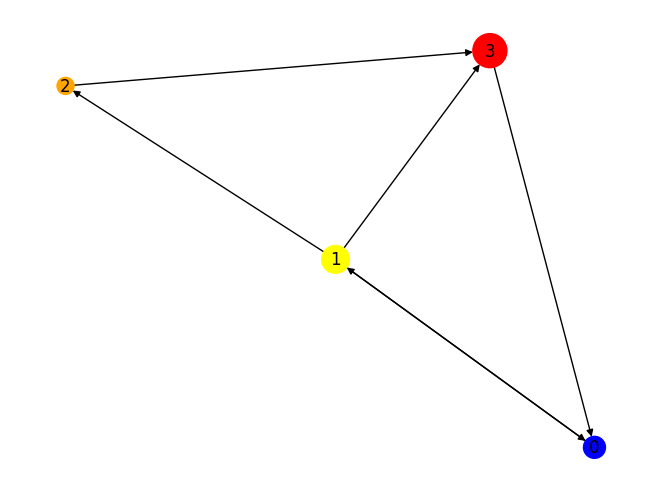

In [ ]:
#Plotting Graph
nx.draw(H, with_labels=True, node_color=colors, node_size=sizes)

In the next step, we will convert the data structure from directional to an undirectional graph using the to_undirected() function.

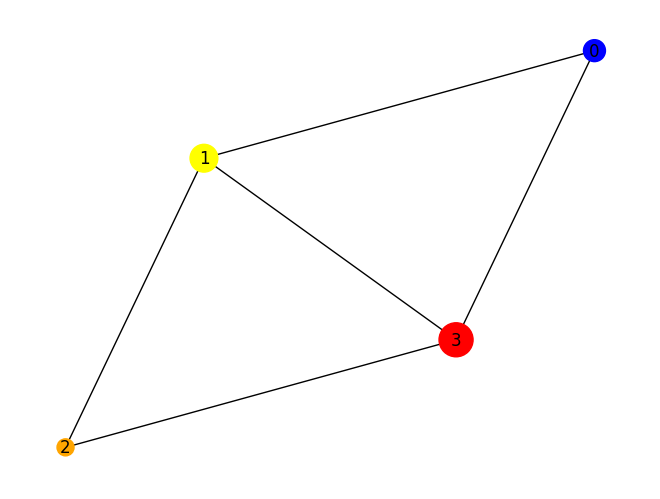

In [ ]:
#converting to undirected graph
G = H.to_undirected()
nx.draw(G, with_labels=True, node_color=colors, node_size=sizes)

## Why is it Hard to Analyze a Graph?

Graph-based data structures have drawbacks, and data scientists must understand them before developing graph-based solutions.

1. A graph exists in non-euclidean space. It does not exist in 2D or 3D space, which makes it harder to interpret the data. To visualize the structure in 2D space, you must use various dimensionality reduction tools.
2. Graphs are dynamic; they do not have a fixed form. There can be two visually different graphs, but they might have similar adjacency matrix representations. It makes it difficult for us to analyze data using traditional statistical tools.
3. Large size and dimensionality will increase the graph's complexity for human interpretations. The dense structure with multiple nodes and thousands of edges is harder to understand and extract insights.


<center>
<img width="400" src="https://images.datacamp.com/image/upload/v1658404111/neural_network_graph_f8afb378d4.png">

<small> Image by [Purvanshi Mehta](httpshttps://medium.com/neuralspace/graphs-neural-networks-in-nlp-dc475eb089de) </small>
 </center>

 The input graph is passed through a series of neural networks. The input graph structure is converted into graph embedding, allowing us to maintain information on nodes, edges, and global context.

Then the feature vector of nodes A and C is passed through the neural network layer. It aggregates these features and passes them to the next layer - [neptune.ai](https://neptune.ai/blog/graph-neural-network-and-some-of-gnn-applications).



Types of Graph Neural Networks

There are several types of neural networks, and most of them have some variation of Convolutional Neural Networks. In this section, we will be learning about the most popular GNNs.

*   Graph Convolutional Networks (GCNs) are similar to traditional CNNs. It learns features by inspecting neighboring nodes. GNNs aggregate node vectors, pass the result to the dense layer, and apply non-linearity using the activation function. In short, it consists of Graph convolution, linear layer, and non-learner activation function. There are two major types of GCNs: Spatial Convolutional Networks and Spectral Convolutional Networks.
*   Graph Auto-Encoder Networks learn graph representation using an encoder and attempt to reconstruct input graphs using a decoder. The encoder and decoders are joined by a bottleneck layer. They are commonly used in link prediction as Auto-Encoders are good at dealing with class balance.
*   Recurrent Graph Neural Networks(RGNNs) learn the best diffusion pattern, and they can handle multi-relational graphs where a single node has multiple relations. This type of graph neural network uses regularizers to boost smoothness and eliminate over-parameterization. RGNNs use less computation power to produce better results. They are used in generating text, machine translation, speech recognition, generating image descriptions, video tagging, and text summarization.
*   Gated Graph Neural Networks (GGNNs) are better than the RGNNs in performing tasks with long-term dependencies. Gated Graph Neural Networks improve Recurrent Graph Neural Networks by adding a node, edge, and time gates on long-term dependencies. Similar to Gated Recurrent Units (GRUs), the gates are used to remember and forget information in different states.


## What is a Graph Neural Network (GNN)?

Graph Neural Networks are special types of neural networks capable of working with a graph data structure. They are highly influenced by Convolutional Neural Networks (CNNs) and graph embedding. GNNs are used in predicting nodes, edges, and graph-based tasks.

* CNNs are used for image classification. Similarly, GNNs are applied to graph structure (grid of pixels) to predict a class.
* Recurrence Neural Networks are used in text classification. Similarly, GNNs are applied to graph structures where every word is a node in a sentence.  

GNNs were introduced when Convolutional Neural Networks failed to achieve optimal results due to the arbitrary size of the graph and complex structure.



Types of Graph Neural Networks Tasks

Below, we’ve outlined some of the types of GNN tasks with examples:

* **Graph Classification**: we use this to classify graphs into various categories. Its applications are social network analysis and text classification.
* **Node Classificatio**n: this task uses neighboring node labels to predict missing node labels in a graph.
*    **Link Prediction**: predicts the link between a pair of nodes in a graph with an incomplete adjacency matrix. It is commonly used for social networks.
*    **Community Detection**: divides nodes into various clusters based on edge structure. It learns from edge weights, and distance and graph objects similarly.
*    **Graph Embedding**: maps graphs into vectors, preserving the relevant information on nodes, edges, and structure.
*    **Graph Generation**: learns from sample graph distribution to generate a new but similar graph structure.

<center>
<img width="500" src="https://images.datacamp.com/image/upload/v1658404112/Types_of_Graph_Neural_Networks_fd300394e8.png">

<small> Image by [Abid Ali Awan](https://www.datacamp.com/portfolio/kingabzpro) </small>
 </center>



Disadvantages of Graph Neural Networks

There are a few drawbacks to using GNNs. Understanding them will help us determine when to use GNNa and how to optimize the performance of our machine learning models.

1. Most neural networks can go deep to obtain better performance, whereas GNNs are shallow networks mostly with three layers. It limits us from achieving state-of-the-art performance on large datasets.
2. The graph structures are constantly changing, making it harder to train a model on it.
3. Deploying the model to production faces scalability issues as these networks are computationally expensive. If you have a large and complex graph structure, it will be hard for you to scale the GNNs in production.


## What is a Graph Convolutional Network (GCN)?

The majority of GNNs are Graph Convolutional Networks, and it is important to learn about them before jumping into a node classification tutorial.  

The convolution in GCN is the same as a convolution in convolutional neural networks. It multiplies neurons with weights (filters) to learn from data features.

It acts as sliding windows on whole images to learn features from neighboring cells. The filter uses weight sharing to learn various facial features in image recognition systems - [Towards Data Science](https://towardsdatascience.com/understanding-graph-convolutional-networks-for-node-classification-a2bfdb7aba7b).

Now transfer the same functionality to Graph Convolutional networks where a model learns the features from neighboring nodes. The major difference between GCN and CNN is that it is developed to work on non-euclidean data structures where the order of nodes and edges can vary.


<center>
<img width="500" src="https://images.datacamp.com/image/upload/v1658404108/CNN_vs_GCN_2ff8e7de66.png">

<small> CNN vs GCN | [Image Source](https://arxiv.org/pdf/1901.00596.pdf) </small>
 </center>



There are two types of GCNs:

* Spatial Graph Convolutional Networks use spatial features to learn from graphs that are located in spatial space.  
* Spectral Graph Convolutional Networks use Eigen-decomposition of graph Laplacian matrix for information propagation along nodes. These networks were inspired by wave propagation in signals and systems.


## How do GNNs Work? Building a Graph Neural Network with Pytorch

We will build and train Spectral Graph Convolution for a node classification model.

The coding examples are influenced by Pytorch geometric documentation.
Getting Started

We will install the Pytorch package as pytorch_geometric is built upon it.

In [ ]:
!pip install -q torch

In [ ]:
%%capture
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

## Creating Simple Graph

In [ ]:
import networkx as nx
H = nx.DiGraph()
H.add_nodes_from([
  (0, {"color": "blue", "size": 250}),
  (1, {"color": "yellow", "size": 400}),
  (2, {"color": "orange", "size": 150}),
  (3, {"color": "red", "size": 600})
])
for node in H.nodes(data=True):
  print(node)

(0, {'color': 'blue', 'size': 250})
(1, {'color': 'yellow', 'size': 400})
(2, {'color': 'orange', 'size': 150})
(3, {'color': 'red', 'size': 600})


In [ ]:
H.add_edges_from([
  (0, 1),
  (1, 2),
  (1, 0),
  (1, 3),
  (2, 3),
  (3,0)
])
print(H.edges())

[(0, 1), (1, 2), (1, 0), (1, 3), (2, 3), (3, 0)]


## Directed Graph

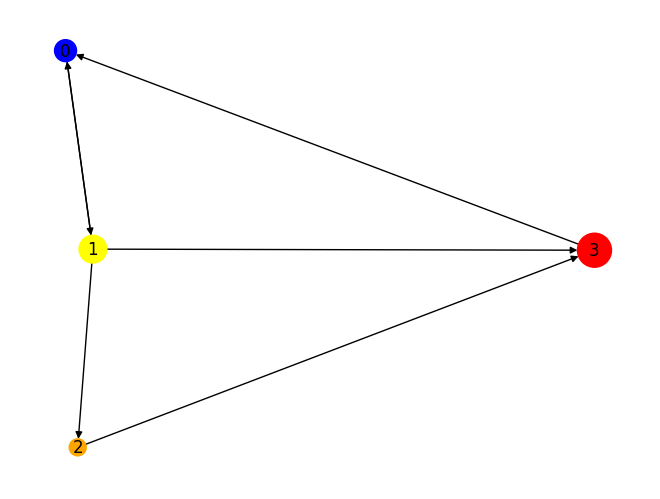

In [ ]:
node_colors = nx.get_node_attributes(H, "color").values()
colors = list(node_colors)
node_sizes = nx.get_node_attributes(H, "size").values()
sizes = list(node_sizes)
nx.draw(H, with_labels=True, node_color=colors, node_size=sizes)

In [ ]:
G = H.to_undirected()
print(G.edges())

[(0, 1), (0, 3), (1, 2), (1, 3), (2, 3)]


## Undirected Graph

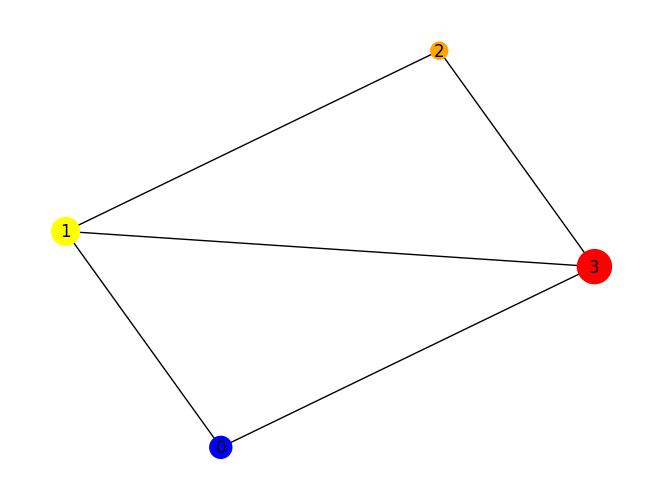

In [ ]:
nx.draw(G, with_labels=True, node_color=colors, node_size=sizes)

## Node Classification with Graph Neural Networks

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


## Training a Graph Neural Network (GNN)

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


### Visulizing Untrained GCN network
7-dimensional node embeddings onto a 2D plane.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

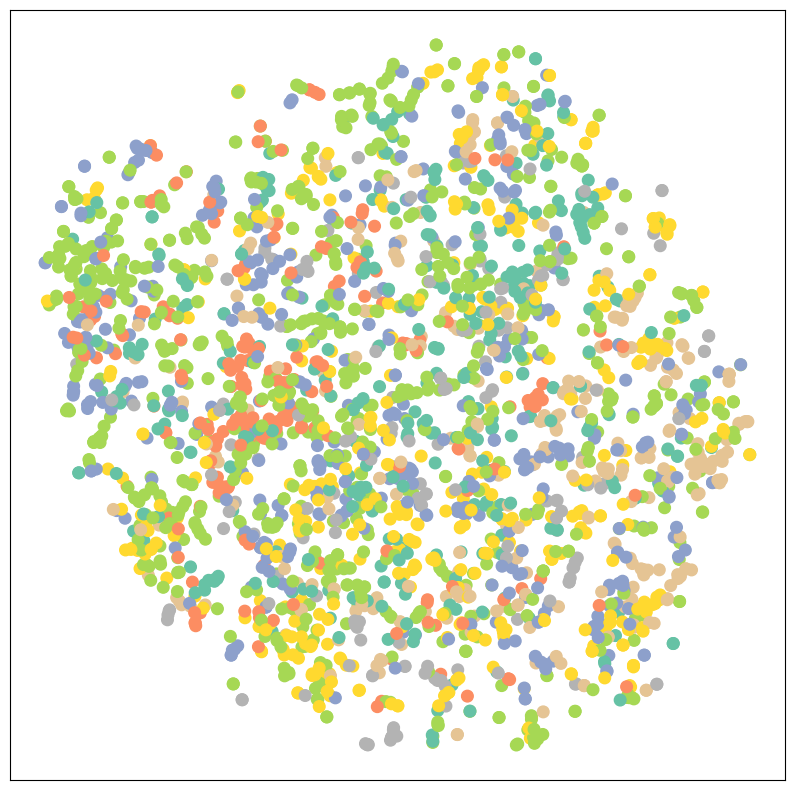

In [ ]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [ ]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


### Evaluation

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


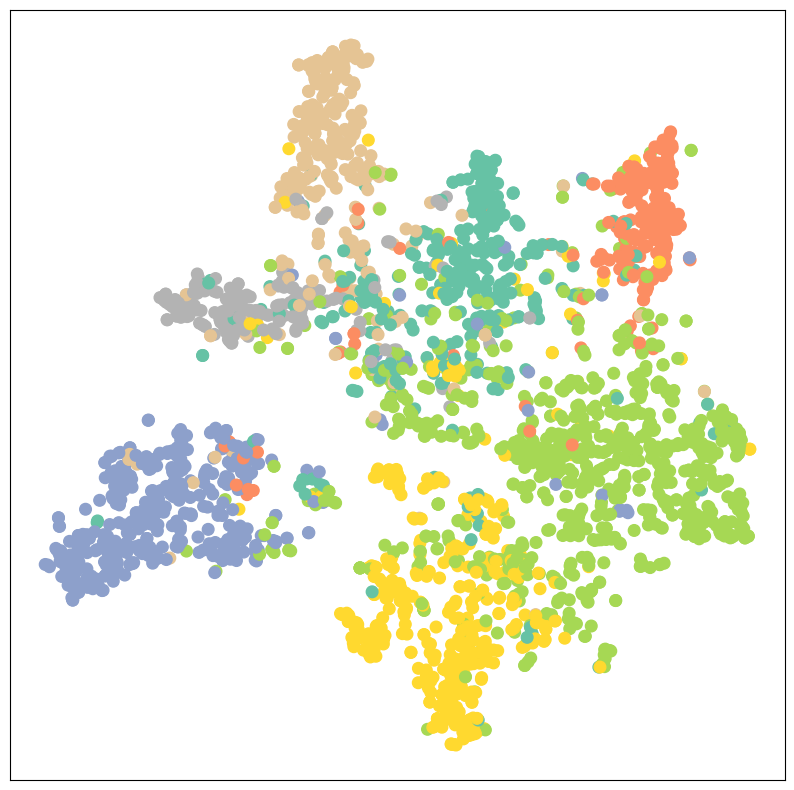

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Training GATConv

In [ ]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)  # TODO
        self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes,heads)  # TODO

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc

val_acc_all = []
test_acc_all = []

for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)
Epoch: 001, Loss: 4.0245, Val: 0.1540, Test: 0.1660
Epoch: 002, Loss: 3.9907, Val: 0.1240, Test: 0.1310
Epoch: 003, Loss: 3.9534, Val: 0.0960, Test: 0.1100
Epoch: 004, Loss: 3.9121, Val: 0.0860, Test: 0.1020
Epoch: 005, Loss: 3.8659, Val: 0.0840, Test: 0.0920
Epoch: 006, Loss: 3.8015, Val: 0.0780, Test: 0.0890
Epoch: 007, Loss: 3.7434, Val: 0.0680, Test: 0.0800
Epoch: 008, Loss: 3.6690, Val: 0.0660, Test: 0.0760
Epoch: 009, Loss: 3.6004, Val: 0.0640, Test: 0.0740
Epoch: 010, Loss: 3.5158, Val: 0.0640, Test: 0.0720
Epoch: 011, Loss: 3.4187, Val: 0.0620, Test: 0.0710
Epoch: 012, Loss: 3.3205, Val: 0.0600, Test: 0.0690
Epoch: 013, Loss: 3.2355, Val: 0.0580, Test: 0.0670
Epoch: 014, Loss: 3.1221, Val: 0.0580, Test: 0.0670
Epoch: 015, Loss: 2.9988, Val: 0.0580, Test: 0.0670
Epoch: 016, Loss: 2.8735, Val: 0.0580, Test: 0.0660
Epoch: 017, Loss: 2.7678, Val: 0.0580, Test: 0.0660
Epoch: 018, Loss: 2.6441, Val: 0.0580

### Evaluation

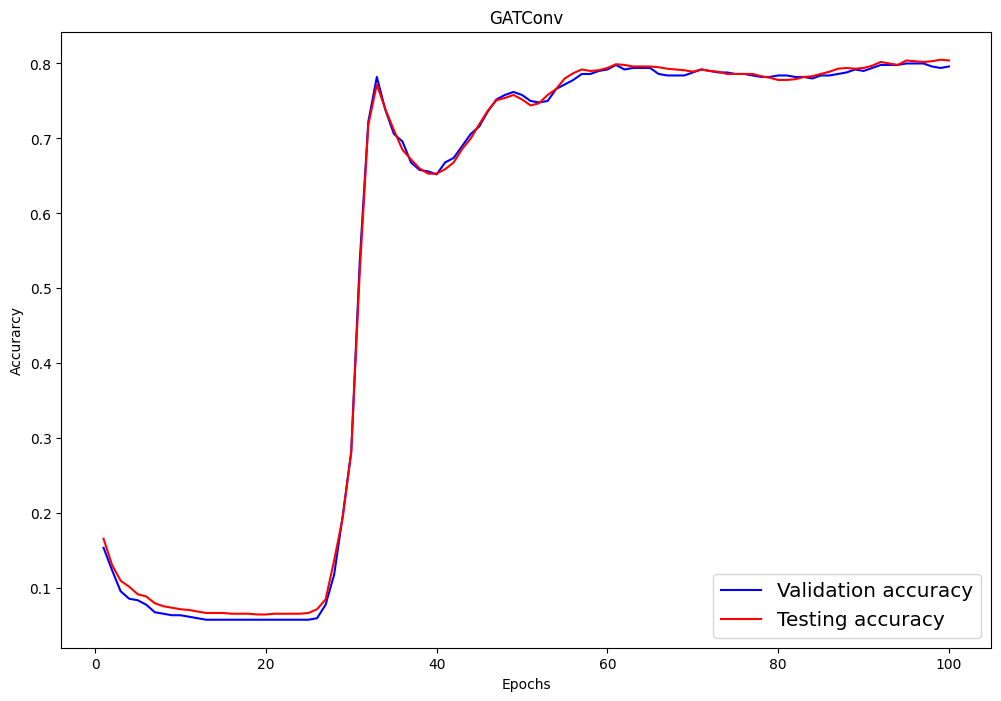

In [ ]:
import numpy as np

plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GATConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gat_loss.png')
plt.show()

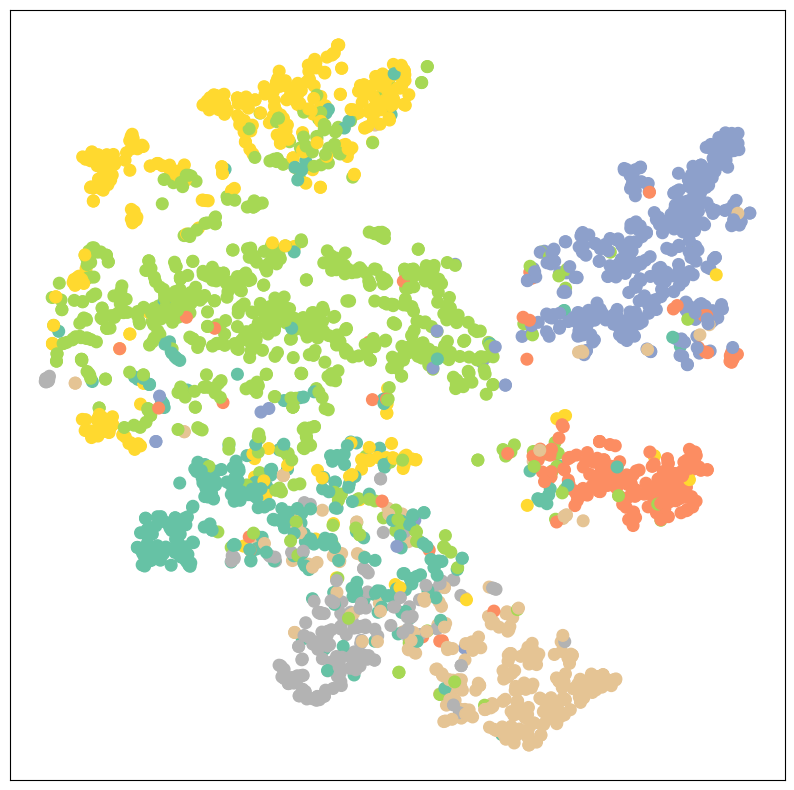

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Introduction to GNNs

By Petar Veličković

In this session of Machine Learning Tech Talks, Senior Research Scientist at DeepMind, Petar Veličković, will give an introductory presentation and Colab exercise on graph neural networks (GNNs).


https://www.youtube.com/watch?v=8owQBFAHw7E

In [ ]:
!pip install numpy
!pip install tensorflow
!pip install spektral
#!pip install spektral==0.6.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
import spektral

In [ ]:
cora_dataset = spektral.datasets.citation.Citation(name='cora')

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


ValueError: ignored

In [ ]:
from spektral.datasets import Cora
cora_dataset = Cora()

In [ ]:
cora_dataset = spektral.datasets.citation.Citation(name='cora')

In [ ]:
adj, features, labels, train_mask, val_mask, test_mask